C:\userdata\takuyai\Miniconda3\envs\lith_nlp\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


41 Unique LithCodes that are not UNKN or numeric
['GRVL' 'CLAY' 'CRSE' 'SHLE' 'BSLT' 'ROCK' 'SAND' 'SOIL' 'GRNT' 'SASH'
 'CGLM' 'SDSN' 'TPSL' 'BLBN' 'COAL' 'SILT' 'LMSN' 'ALVM' 'QRTZ' 'SDCY'
 'LOAM' 'BLDR' 'SLTE' 'SLCY' 'BNST' 'VLCC' 'SLSN' 'BRBN' 'GRBN' 'MDSN'
 'WB' 'TUFF' 'BDRK' 'SNDY' 'SDMN' 'CVTY' 'CLBD' 'FILL' 'DLMT' 'WODY'
 'FINE']
Attempting to fill in 99 unknown MajorLithCode based on provided descriptions


100%|█████████████████████████████████████████████████████████████████| 99/99 [00:31<00:00,  3.11it/s]


After clean up 40 unique LithCodes that are not UNKN or numeric
['GRVL' 'CLAY' 'CRSE' 'SHLE' 'BSLT' 'ROCK' 'SAND' 'SOIL' 'TPSL' 'GRNT'
 'SASH' 'CGLM' 'SDSN' 'COAL' 'SILT' 'LMSN' 'ALVM' 'QRTZ' 'SDCY' 'LOAM'
 'BLDR' 'SLTE' 'SLCY' 'VLCC' 'SLSN' 'BRBN' 'GRBN' 'MDSN' 'TUFF' 'WB'
 'BDRK' 'SNDY' 'SDMN' 'CVTY' 'CLBD' 'FILL' 'DLMT' 'WODY' 'BNST' 'FINE']
(1000,) (1000,)
Number of entries 1000
Dictionary(135 unique tokens: ['bear', 'cement', 'ggravel', 'water', 'clay']...)


notebook_setup.ipynb:8: UserWarning: WARNING - Filtering to unique combinations, which may not be desirable in the future!
  "source": [


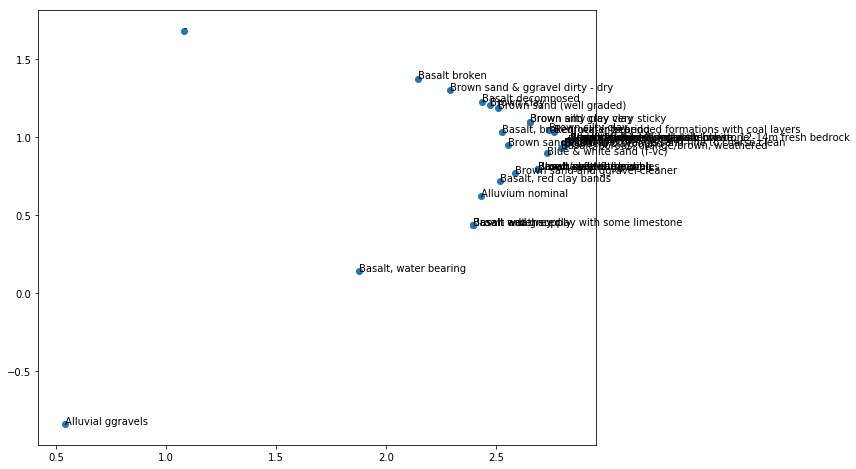

In [1]:
%run notebook_setup.ipynb

In [2]:
import os
import nltk
from scipy.cluster.hierarchy import ward, dendrogram
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

In [3]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

### Load sampled Data 

In [4]:
DF = lith_df  # alias data loaded from notebook_setup

### For each description a list of tokens is generated without stopwords

In [5]:
objectID=DF.OBJECTID.tolist()
Descriptions=DF.Description.tolist()
Descriptions = [str(n) for n in Descriptions]
if 'nan' in Descriptions:
    remove = Descriptions.index('nan')
    del Descriptions[remove]
    del objectID[remove]

#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in Descriptions:
    allwords_stemmed = tokenize_and_stem(i, stopwords) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend([allwords_stemmed]) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i, stopwords)
    totalvocab_tokenized.extend([allwords_tokenized])

print(np.shape(totalvocab_tokenized),  np.shape(totalvocab_stemmed))

(1000,) (1000,)


## Alternate stemming process

In [6]:
lith_code_desc, all_words, word_map = merge_similar_words(lith_code_desc, stopwords, target_columns)

In [7]:
totalvocab_stemmed = lith_code_desc.tokens

### Dictionary and corpus developed from the list of tokens

In [8]:
###here just tokens or stemmed tokens can be used alternatively
dictionary = gensim.corpora.Dictionary(totalvocab_stemmed)
## newt two lines remove tokens contained just once in the dictionary
once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
dictionary.filter_tokens(once_ids)

dictionary.compactify()
print(dictionary)
corpus = [dictionary.doc2bow(text) for text in totalvocab_stemmed]
print('length corpus', len(corpus))

Dictionary(115 unique tokens: ['alluvi', 'gravel', 'min', 'suppli', 'water']...)
length corpus 558


# Then different model transformations from gensim can be used

# Let's first use the TF-IDF

In [9]:
%time tfidf = gensim.models.TfidfModel(corpus, normalize = True)

Wall time: 1e+03 µs


#### Similarity can be computed as a matrix or just similarities (the last one doesn't load the entire matrix into the memory)

In [10]:
tfidfSim = gensim.similarities.MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))
tfidfSimMatrix =[]
for n in totalvocab_stemmed:
    vec_bow = dictionary.doc2bow(n)
    vec_tfidf = tfidf[vec_bow]
    sims1 = tfidfSim[vec_tfidf]
    tfidfSimMatrix.append(sims1)
tfidfDisMatrix = 1- np.array(tfidfSimMatrix) 

### Then the hierarchical clustering can be carried out with the matrix of disimilarities 

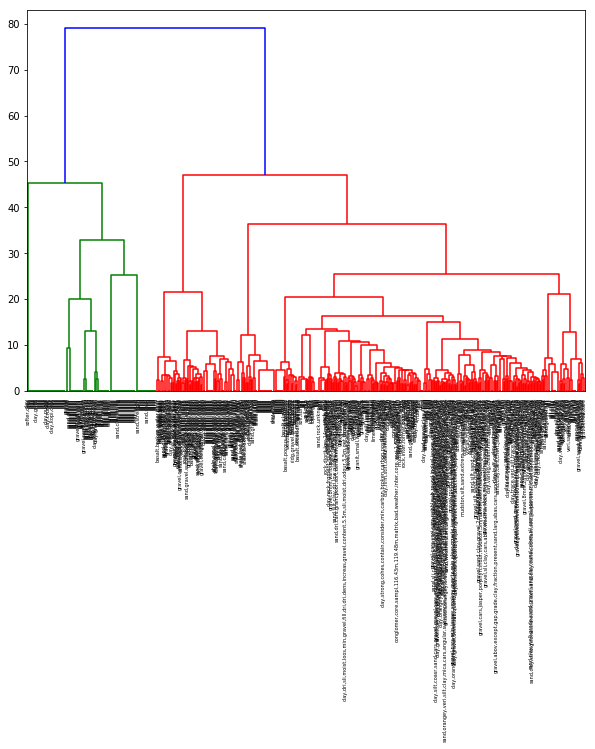

In [11]:
linkage_matrix = linkage(tfidfDisMatrix, 'ward')

fig, ax = plt.subplots(figsize=(10, 7)) # set size
ax = dendrogram(linkage_matrix,
                #orientation="right",
                labels=[','.join(x) for x in totalvocab_stemmed]);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')#,         # ticks along the top edge are off
    #labelbottom='off')

plt.show()

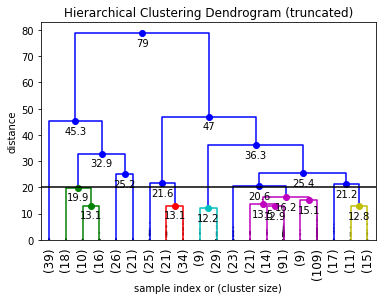

In [12]:
# set cut-off to 50
max_d = 20  # max_d as in max_distance

fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

### Retrieve the clusters

In [13]:
max_d = 20
clusters = fcluster(linkage_matrix, max_d, criterion='distance')

try:
    DF['cluster'] = clusters.tolist()
    print(DF[['Description', 'cluster']].head())
    print("Num clusters:", len(np.unique(DF.cluster)))
except ValueError:
    lith_code_desc['cluster'] = clusters.tolist()
    print(lith_code_desc[['Description', 'cluster']].head(10))
    print("Num clusters:", len(np.unique(lith_code_desc.cluster)))

               Description  cluster
0                        -        9
1        Alluvial ggravels        9
2                 Alluvium        9
3         Alluvium nominal        9
4    Alluvium water supply        6
5                As above.        9
6                   Basalt        8
7  Basalt - water  bearing        5
8            Basalt broken        8
9        Basalt decomposed        8
Num clusters: 11


# Let's try the Latent Semantic Indexing, LSI (or sometimes LSA). The description in the gensim tutorials is as follows:

#### transforms documents from either bag-of-words or (preferrably) TfIdf-weighted space into a latent space of a lower dimensionality. For the toy corpus above we used only 2 latent dimensions, but on real corpora, target dimensionality of 200–500 is recommended as a “golden standard”

In [14]:
##As the tutorial suggests, we'll use the model over the TFIDF transformation that we carried out
lsi = gensim.models.LsiModel(tfidf[corpus], id2word=dictionary, num_topics=300)

lsiSim = gensim.similarities.MatrixSimilarity(lsi[corpus])
lsiSimMatrix =[]
for n in totalvocab_stemmed:
    vec_bow = dictionary.doc2bow(n)
    vec_lsi = lsi[vec_bow]
    sims1 = lsiSim[vec_lsi]
    lsiSimMatrix.append(sims1)
lsiDisMatrix = 1- np.array(lsiSimMatrix) 

### Then the hierarchical clustering

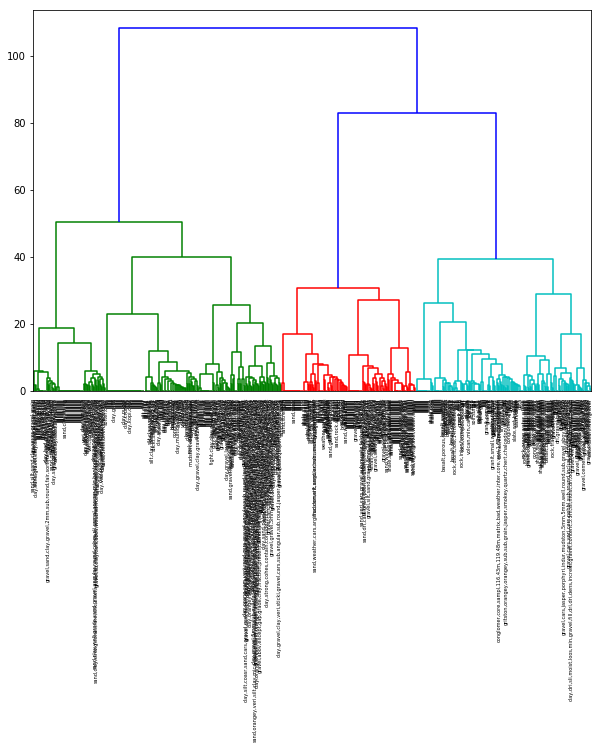

In [15]:
linkage_matrix = ward(lsiDisMatrix)

fig, ax = plt.subplots(figsize=(10, 7)) # set size
ax = dendrogram(linkage_matrix,
                #orientation="right",
                labels=[','.join(x) for x in totalvocab_stemmed]);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')#,         # ticks along the top edge are off
    #labelbottom='off')

plt.show()

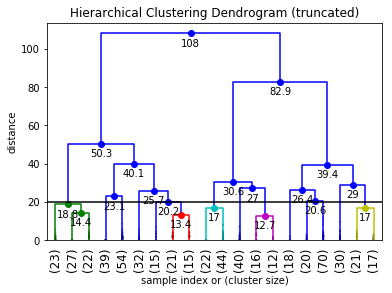

In [16]:
# set cut-off to 50
max_d = 20  # max_d as in max_distance

fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

### retrieve the clusters

In [17]:
max_d = 20
clusters = fcluster(linkage_matrix, max_d, criterion='distance')

try:
    DF['cluster'] = clusters.tolist()
    print(DF[['Description', 'cluster']].head())
    print("Num clusters:", len(np.unique(DF.cluster)))
except ValueError:
    lith_code_desc['cluster'] = clusters.tolist()
    print(lith_code_desc[['Description', 'cluster']].head(10))
    print("Num clusters:", len(np.unique(lith_code_desc.cluster)))

               Description  cluster
0                        -       12
1        Alluvial ggravels       14
2                 Alluvium       12
3         Alluvium nominal       12
4    Alluvium water supply       13
5                As above.       12
6                   Basalt       11
7  Basalt - water  bearing       13
8            Basalt broken       11
9        Basalt decomposed       11
Num clusters: 14


# Let's try the Latent Dirichlet Allocation, LDA. 
#### Here is the description from gensim: is yet another transformation from bag-of-words counts into a topic space of lower dimensionality. LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. These distributions are, just like with LSA, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (again, just like with LSA). 

In [18]:
%time lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=50, update_every=5, chunksize=10000, passes=10)

Wall time: 5.87 s


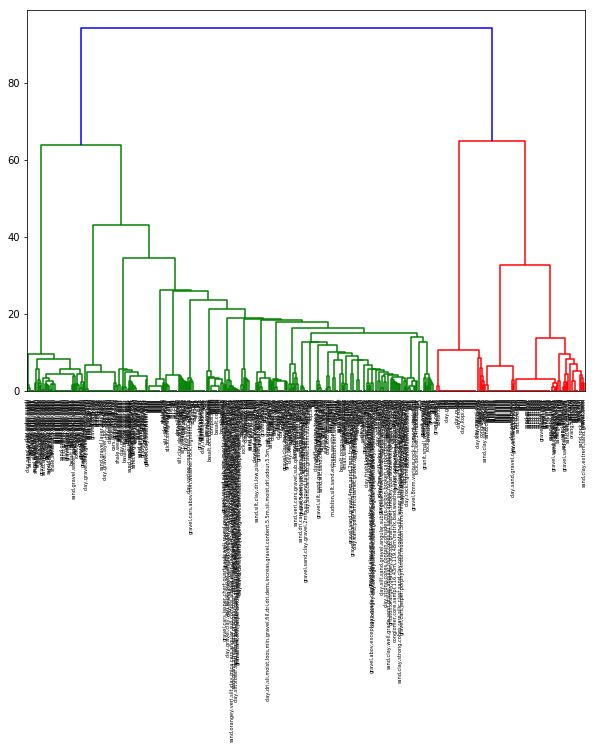

In [19]:
ldaSim = gensim.similarities.MatrixSimilarity(lda[corpus])
ldaSimMatrix =[]
for n in totalvocab_stemmed:
    vec_bow = dictionary.doc2bow(n)
    vec_lda = lda[vec_bow]
    sims1 = ldaSim[vec_lda]
    ldaSimMatrix.append(sims1)
ldaDisMatrix = 1- np.array(ldaSimMatrix) 

##hierarchical clustering
linkage_matrix = ward(ldaDisMatrix)

fig, ax = plt.subplots(figsize=(10, 7)) # set size
ax = dendrogram(linkage_matrix,
                #orientation="right",
                labels=[','.join(x) for x in totalvocab_stemmed]);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')#,         # ticks along the top edge are off
    #labelbottom='off')

plt.show()


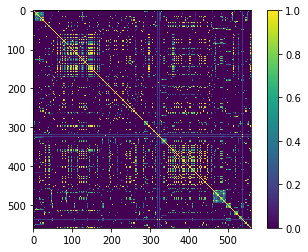

In [20]:
plt.imshow(np.array(ldaSimMatrix))
plt.colorbar()

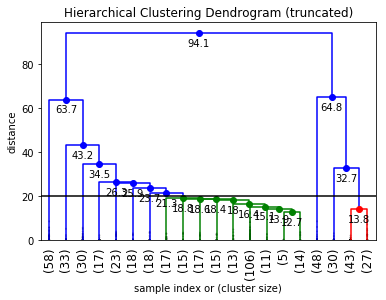

In [21]:
# set cut-off to 50
max_d = 20  # max_d as in max_distance

fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

### Retrieve the clusters

In [22]:
max_d = 20
clusters = fcluster(linkage_matrix, max_d, criterion='distance')

try:
    DF['cluster'] = clusters.tolist()
    print(DF[['Description', 'cluster']].head())
    print("Num clusters:", len(np.unique(DF.cluster)))
except ValueError:
    lith_code_desc['cluster'] = clusters.tolist()
    print(lith_code_desc[['Description', 'cluster']].head(10))
    print("Num clusters:", len(np.unique(lith_code_desc.cluster)))

               Description  cluster
0                        -        8
1        Alluvial ggravels        8
2                 Alluvium        8
3         Alluvium nominal        8
4    Alluvium water supply        1
5                As above.        6
6                   Basalt        7
7  Basalt - water  bearing        3
8            Basalt broken        7
9        Basalt decomposed        7
Num clusters: 11


# Hierarchical Dirichlet Process, HDP is a non-parametric bayesian method (note the missing number of requested topics)

Wall time: 1.19 s


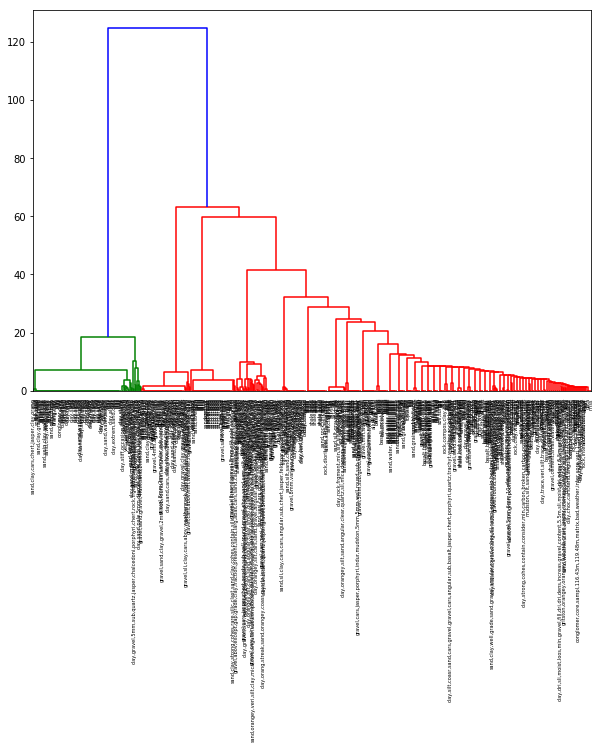

In [23]:
%time hdp = gensim.models.HdpModel(corpus, id2word=dictionary)
hdpSim = gensim.similarities.MatrixSimilarity(hdp[corpus])
hdpSimMatrix =[]
for n in totalvocab_stemmed:
    vec_bow = dictionary.doc2bow(n)
    vec_hdp = hdp[vec_bow]
    sims1 = hdpSim[vec_hdp]
    hdpSimMatrix.append(sims1)
hdpDisMatrix = 1- np.array(hdpSimMatrix) 

##hierarchical clustering
linkage_matrix = ward(hdpDisMatrix)

fig, ax = plt.subplots(figsize=(10, 7)) # set size
ax = dendrogram(linkage_matrix,
                #orientation="right",
                labels=[','.join(x) for x in totalvocab_stemmed]);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')#,         # ticks along the top edge are off
    #labelbottom='off')

plt.show()


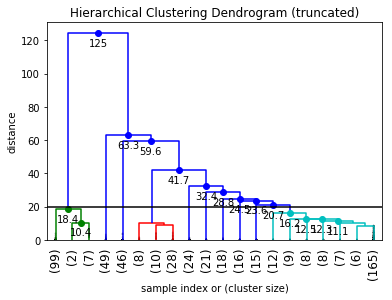

In [24]:
# set cut-off to 50
max_d = 20  # max_d as in max_distance

fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

### Retrieve clusters

In [25]:
max_d = 20
clusters = fcluster(linkage_matrix, max_d, criterion='distance')

try:
    DF['cluster'] = clusters.tolist()
    print(DF[['Description', 'cluster']].head())
    print("Num clusters:", len(np.unique(DF.cluster)))
except ValueError:
    lith_code_desc['cluster'] = clusters.tolist()
    print(lith_code_desc[['Description', 'cluster']].head())
    print("Num clusters:", len(np.unique(lith_code_desc.cluster)))

             Description  cluster
0                      -       10
1      Alluvial ggravels        9
2               Alluvium       10
3       Alluvium nominal        9
4  Alluvium water supply       10
Num clusters: 10


# Log entropy model

Wall time: 2 ms


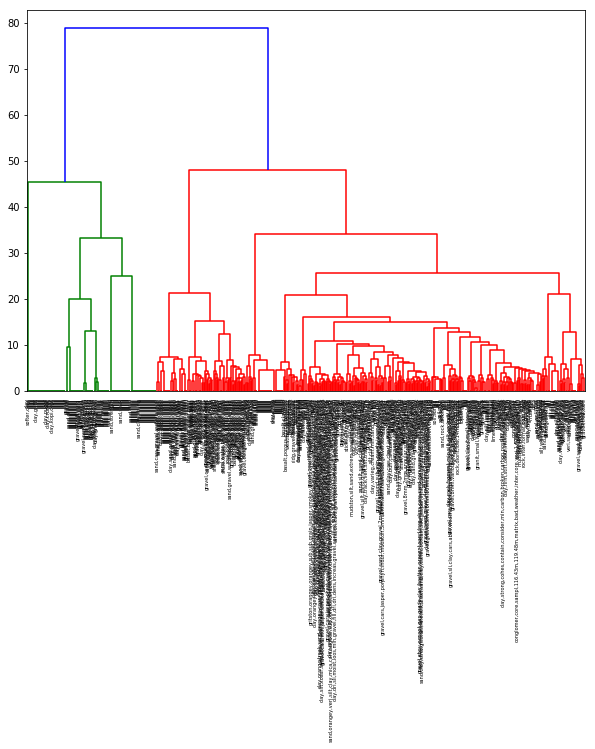

In [26]:
%time word = gensim.models.LogEntropyModel(corpus)
wordSim = gensim.similarities.MatrixSimilarity(word[corpus])
wordSimMatrix =[]
for n in totalvocab_stemmed:
    vec_bow = dictionary.doc2bow(n)
    vec_word = word[vec_bow]
    sims1 = wordSim[vec_word]
    wordSimMatrix.append(sims1)
wordDisMatrix = 1 - np.array(wordSimMatrix) 

##hierarchical clustering
linkage_matrix = ward(wordDisMatrix)

fig, ax = plt.subplots(figsize=(10, 7)) # set size
ax = dendrogram(linkage_matrix,
                #orientation="right",
                labels=[','.join(x) for x in totalvocab_stemmed]);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')#,         # ticks along the top edge are off
    #labelbottom='off')

plt.show()

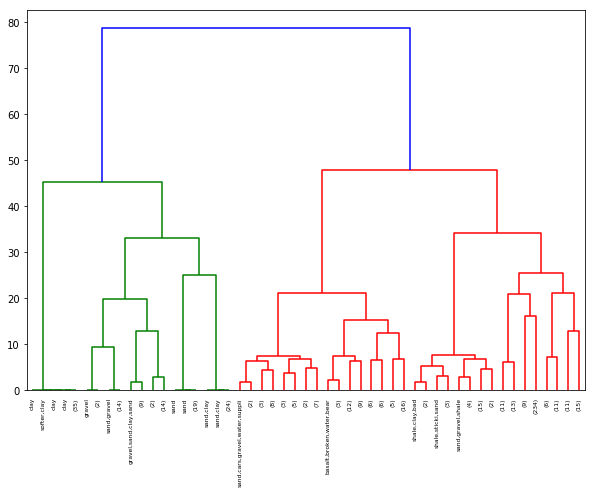

In [27]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 7)) # set size
ax = dendrogram(linkage_matrix,
                #orientation="right",
                labels=[','.join(x) for x in totalvocab_stemmed],
               truncate_mode='level', p=5);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')#,         # ticks along the top edge are off
    #labelbottom='off')

# plt.show()

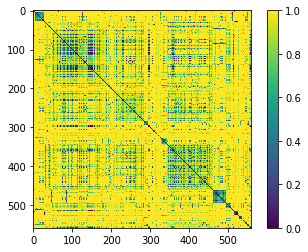

In [28]:
plt.imshow(wordDisMatrix)
plt.colorbar()

In [29]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(1 - np.array(wordSimMatrix))

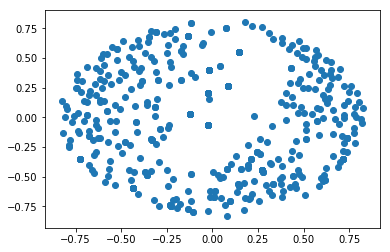

In [30]:
plt.scatter(pos[:, 0], pos[:, 1])

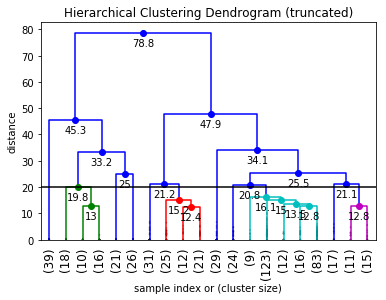

In [31]:
# set cut-off to 50
max_d = 20  # max_d as in max_distance

fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

### Retrieve clusters

In [32]:
max_d = 20
clusters = fcluster(linkage_matrix, max_d, criterion='distance')

try:
    DF['cluster'] = clusters.tolist()
    print(DF[['Description', 'cluster']].head())
    print("Num clusters:", len(np.unique(DF.cluster)))
except ValueError:
    lith_code_desc['cluster'] = clusters.tolist()
    print(lith_code_desc[['Description', 'cluster']].head(60))
    print("Num clusters:", len(np.unique(lith_code_desc.cluster)))

                                          Description  cluster
0                                                   -        9
1                                   Alluvial ggravels        9
2                                            Alluvium        9
3                                    Alluvium nominal        9
4                               Alluvium water supply        6
5                                           As above.        9
6                                              Basalt        8
7                             Basalt - water  bearing        6
8                                       Basalt broken        8
9                                   Basalt decomposed        8
10                      Basalt fractured water supply        6
11                                   Basalt grey hard        8
12                                        Basalt hard        8
13                                        Basalt soft        8
14                                   Basalt very hard  